<center><h1 style="color:#173F8A;"> Metodos para Ecuaciones Diferenciales, IMT3410, 2024-2 </h1></center>
<h3 style="color:#173F8A;text-align:right;"> Instituto de Ingenieria Matematica y Computacional<br>  Pontificia Universidad Catolica de Chile <br>  </h3>
<h3 style="color:#0176DE;text-align:right;"> Profesor. Manuel A. Sanchez<br> </h3>
<hr style="border:2px solid #03122E"> </hr>

<!-- Palette colors UC: celeste:#0176DE, azul #173F8A, azul oscuro: #03122E, amarillo: #FEC60D, amarillo oscuro: #E3AE00 -->
<!--
<figure>
<img align ="right" src="IMClogo.png" alt="logo" width="250" height="400"><br><br><br><br><br>
</figure>
 -->

## Capitulo 2: Mi primer codigo de elementos finitos

## Problema: 
Queremos resolver la siguiente ecuacion eliptica
$$
-\frac{d}{dx}\left( p(x) \frac{d}{dx}u(x)\right) + q(x)\frac{d}{dx}u(x)+ r(x)u(x) = f(x),\quad x\in (a,b)
$$
con condiciones de borde $u(a) = A, u(b) = B$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import roots_jacobi

In [181]:
# Datos
class problem1delliptic:
    def __init__(self,a,b,f,A,B,p,q,r,dp,uexact=None,duexact=None,K0=None):
        self.a = a
        self.b = b
        self.f = f
        self.A = A
        self.B = B
        self.p = p
        self.dp = dp
        self.q = q
        self.r = r
        self.uexact = uexact
        self.duexact = duexact
        self.K0=K0

# problema ejemplo
a = 0.0; b= 1.0
f = lambda x: 2.0 +0*x
A = .0; B = .0
p = lambda x: 1.0+0*x
r = lambda x: 0+0*x
dp = lambda x: 0*x
q = lambda x: 0+0*x
uexact = lambda x: x*(1.0-x) 
problema1 = problem1delliptic(a,b,f,A,B,p,q,r,dp)

In [182]:
# Triangulacion o subdivision del intervalo
class Triangulation1d:
    def __init__(self, Coordinates, Elements1d, Boundary):
        self.Coordinates = Coordinates
        self.Elements = Elements1d
        self.Boundary = Boundary
        self.NN = Coordinates.size
        self.NE = Elements1d.shape[0]
    def refinement(self, marked_Elementsindex):
        # the boundary nodes do not change!
        oldElementsindex = np.setdiff1d(np.arange(self.NE), marked_Elementsindex)
        newElements = self.Elements[oldElementsindex,:].tolist()
        newCoordinates = self.Coordinates.tolist()
        NN = self.Coordinates.size
        for j,Kj in enumerate(marked_Elementsindex):
            K = self.Coordinates[self.Elements[Kj,:]]
            newX = 0.5*(K[1]+K[0]); newCoordinates.append(newX)
            # split K ===> K1 U K2
            K1 = [self.Elements[Kj,0], NN+j]; K2 = [NN+j, self.Elements[Kj,1]]
            newElements.append(K1);newElements.append(K2)
        self.Coordinates = np.asarray(newCoordinates)
        self.Elements = np.asarray(newElements)
         
        self.NN = self.Coordinates.size
        self.NE = self.Elements.shape[0]
    def plotTriangulation(self, fig=None):
        if fig is None:
            fig = plt.figure()
        ax = fig.add_subplot()
        ax = plt.plot(self.Coordinates, np.zeros(self.NN),'-+',color ='C07')
        return fig
        
# ejemplo de triangulacion
npoints = 10
# x = np.random.rand(npoints-2); z = a + (b-a)*x
z = np.linspace(0,1,npoints,endpoint=True)
# print(z)
# Coordinates = np.concatenate( (np.array([a]),np.sort(z),np.array([b])) )
Coordinates = z
Elements1d = np.asarray([[i, i+1] for i in range(npoints-1)])
mesh1d = Triangulation1d(Coordinates, Elements1d, Boundary=[0,npoints-1])

In [183]:
def myfirstfem1d(problem, mesh):
    # Matrix 
    A = np.zeros((mesh.NN, mesh.NN), dtype=np.float64)
    # vector
    b = np.zeros(mesh.NN, dtype=np.float64)
    # solution
    uh = np.zeros(mesh.NN, dtype=np.float64)
    #
    x,w = roots_jacobi(n=2,alpha=0,beta=0)
    def computeStiffness1d(K,pfun):
        # compute integral p(x)*phi_i'*phi_j' dx
        hi = np.abs(K[1]-K[0])
        gradgrad = (1.0/hi**2)*np.outer(np.array([-1.0,1.0]), np.array([-1.0,1.0]))
        y = (K[1]-K[0])/2*(x+1.0)+K[0] 
        return (hi/2.0*np.sum(w*pfun(y), axis=-1)) * gradgrad
    
    def computeMass1d(K,rfun): 
        # compute integral r(x)*phi_i*phi_j dx
        hi = np.abs(K[1]-K[0])
        y = (K[1]-K[0])/2*(x+1.0)+K[0] 
        MK = np.array([[np.sum(w*rfun(y)*(1-x)**2, axis=-1)   ,np.sum(w*rfun(y)*(1-x)*(1+x), axis=-1)],
                       [np.sum(w*rfun(y)*(1+x)*(1-x), axis=-1),np.sum(w*rfun(y)*(1+x)**2, axis=-1)   ]])
        return hi/8.0*MK
    
    def computeConvection1d(L,qfun):
        # compute integral q(x)*phi_i'*phi_j dx
        hi = np.abs(K[1]-K[0])
        y = (K[1]-K[0])/2*(x+1.0)+K[0] 
        BK = np.array([[-np.sum([w[i]*qfun(y[i])*(1.0-x[i]) for i in range(x.size)], axis=-1) , np.sum(w*qfun(y)*(1-x), axis=-1)],
                       [-np.sum([w[i]*qfun(y[i])*(1.0+x[i]) for i in range(x.size)], axis=-1)  , np.sum(w*qfun(y)*(1+x), axis=-1)   ]])
        return (1.0/4.0)*BK
    
    def computeloadvector1d(K,ffun):
        # compute integral f(x)*phi_i dx
        hi = np.abs(K[1]-K[0])
        y = (K[1]-K[0])/2*(x+1.0)+K[0] 
        bK = np.array([np.sum([w[i]*ffun(y[i])*(1.0-x[i]) for i in range(x.size)], axis=-1), np.sum(w*ffun(y)*(1+x), axis=-1)])
        return hi/4.0*bK
    
    # Loop over elements
    for j in range(mesh.NE):
        # element
        K = mesh.Coordinates[mesh.Elements[j,:]]
        # local stiffness matrix
        SK = computeStiffness1d(K,problem.p)
        # local convection matrix
        BK = computeConvection1d(K, problem.q)
        # local mas matrix 
        MK = computeMass1d(K,problem.r)
        # local assembling matrix A+= AK = SK+MK
        dofK = mesh.Elements[j,:]
        A[np.ix_(dofK, dofK)] += SK+BK+MK 
        # load vector
        bK = computeloadvector1d(K, problem.f)
        # local assembling vector b += bK
        b[dofK] += bK
    # end loop
    
    # Dirichlet boundary condicion
    uh[mesh.Boundary[0]] = problem.A; uh[mesh.Boundary[1]] = problem.B
    b = b - A.dot(uh)
    Freenodes = np.setdiff1d(np.arange(mesh.NN), mesh.Boundary)
    # slicing
    AFree = A[np.ix_(Freenodes, Freenodes)]  
    # solve linear system AFree uh[Free] = b[Free] 
    uh[Freenodes] = np.linalg.solve(AFree, b[Freenodes])
    return uh

In [184]:
uh = myfirstfem1d(problema1, mesh1d)

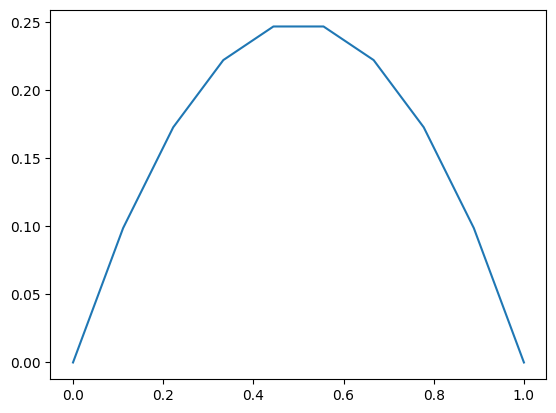

In [185]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(Coordinates, uh)
# fig = mesh1d.plotTriangulation(fig)
plt.show()

## Problema: solucion lineal $u(x) = 1-x$

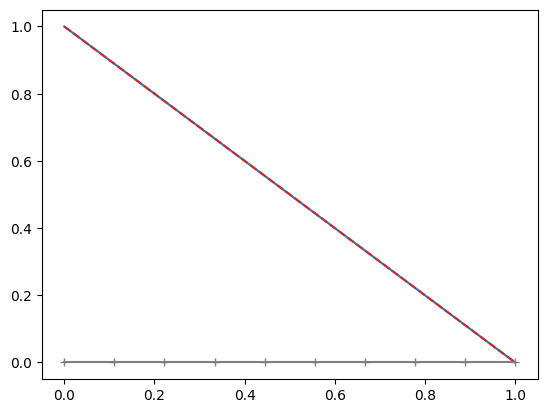

In [186]:
## New problem
a = 0.0; b= 1.0
f = lambda x:  4.0*(-1) + 5.0 * (1.0-x)
A = 1.0; B = .0
p = lambda x: 1.0+0*x
r = lambda x: 5.0+0*x
dp = lambda x: 0*x
q = lambda x: 4.0+.0*x
uexact = lambda x: (1-x)

problema = problem1delliptic(a,b,f,A,B,p,q,r,dp)

npoints=10
Coordinates = np.linspace(a,b,npoints,endpoint=True)
Elements1d = np.asarray([[i, i+1] for i in range(npoints-1)])
mesh = Triangulation1d(Coordinates, Elements1d, Boundary=[0,npoints-1])

uh = myfirstfem1d(problema, mesh)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(mesh.Coordinates, uh,'C00')
ax.plot(mesh.Coordinates, np.zeros(mesh.NN),'-+',color ='C07')
ax.plot(mesh.Coordinates, uexact(mesh.Coordinates),'--',color ='C03')
plt.show()

## A posteriori

### Primero tenemos el refinamiento de la malla, marcando intervalos y refinandolos por la mitad

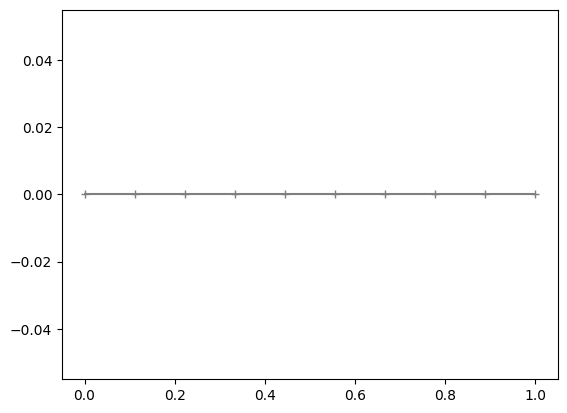

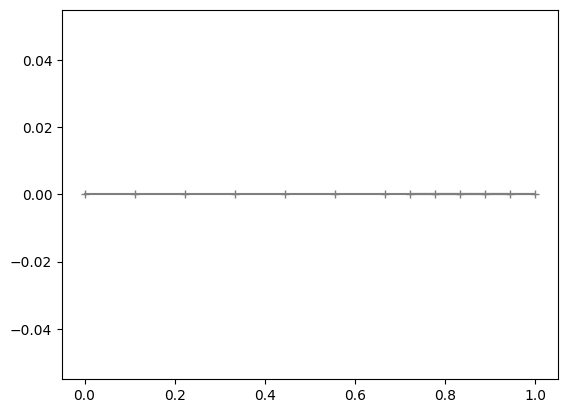

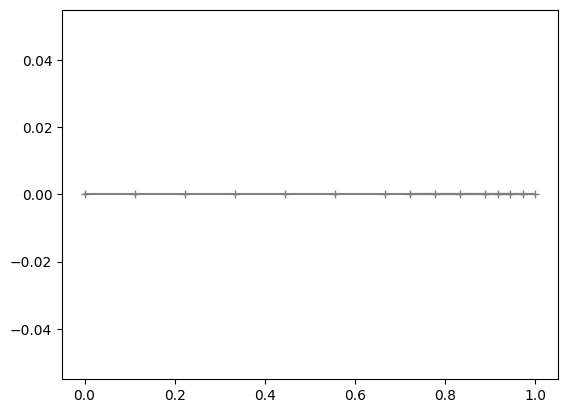

In [187]:
# Triangulacion uniforme
npoints = 10
z = np.linspace(0,1,npoints,endpoint=True)
Coordinates = z
Elements1d = np.asarray([[i, i+1] for i in range(npoints-1)])
mesh = Triangulation1d(Coordinates, Elements1d, Boundary=[0,npoints-1])
fig = mesh.plotTriangulation()
markedTri = [6,7,8]
mesh.refinement(marked_Elementsindex=markedTri)
fig = mesh.plotTriangulation()
markedTri = [10,11]
mesh.refinement(marked_Elementsindex=markedTri)
fig = mesh.plotTriangulation()

## Problema 3: solucion cuadratica

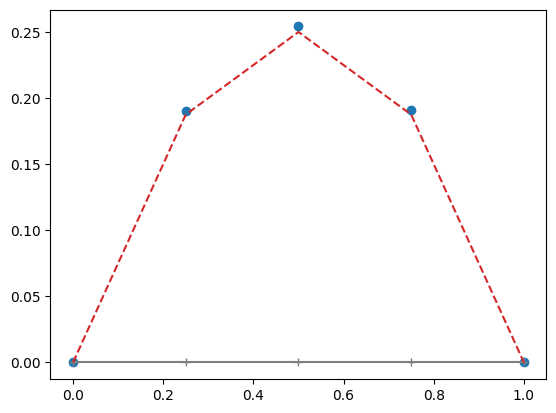

 La tolerancia no se alcanzo, R =0.0653758760470707, se refino nuevamente la malla


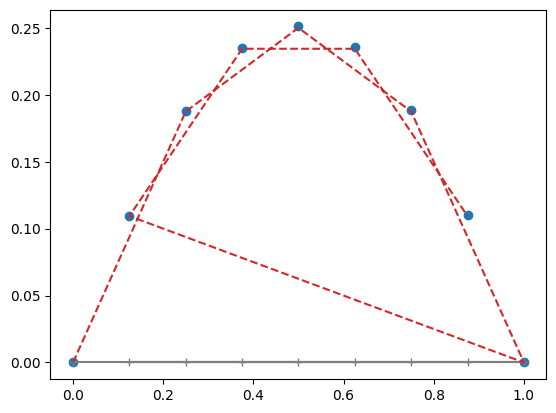

In [191]:
## New problem
a = 0.0; b= 1.0
f = lambda x: 2.0 + 2.0*(-2*x+1) + 5.0 * x * (1-x)
A = .0; B = .0
p = lambda x: 1.0+0*x
r = lambda x: 5.0+0*x
dp = lambda x: 0*x
q = lambda x: 2.0+.0*x
uexact = lambda x: x*(1-x)

problema = problem1delliptic(a,b,f,A,B,p,q,r,dp,K0=K0)

npoints=5
Coordinates = np.linspace(a,b,npoints,endpoint=True)
Elements1d = np.asarray([[i, i+1] for i in range(npoints-1)])
mesh = Triangulation1d(Coordinates, Elements1d, Boundary=[0,npoints-1])

uh = myfirstfem1d(problema, mesh)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(mesh.Coordinates, uh,'o',color='C00')
ax.plot(mesh.Coordinates, np.zeros(mesh.NN),'-+',color ='C07')
ax.plot(mesh.Coordinates, uexact(mesh.Coordinates),'--',color ='C03')
plt.show()
success, mesh1 = compute_apostestimator(mesh, uh, problema)


uhr = myfirstfem1d(problema, mesh1)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(mesh1.Coordinates, uhr,'o',color='C00')
ax.plot(mesh1.Coordinates, np.zeros(mesh1.NN),'-+',color ='C07')
ax.plot(mesh1.Coordinates, uexact(mesh1.Coordinates),'--',color ='C03')
plt.show()

## Estimador de error a posteriori

In [190]:
def compute_apostestimator(mesh, uh, problem, TOL=1e-2):
    if problem.K0 is None:
        K0 = 1.0
    else:
        K0 = problem.K0
    x,w = roots_jacobi(n=4,alpha=0,beta=0)
    # compute \|R(uh)\|^2 
    R = np.zeros(mesh.NE)
    marked_Elementsindex = []
    NUMTOL = 1.0/mesh.NN*(TOL/K0)**2
    for j in range(mesh.NE):
        dofK = mesh.Elements[j,:]; uK = uh[dofK]
        K = mesh.Coordinates[mesh.Elements[j,:]]; hK = abs(K[1]-K[0])
        duh = (-uK[0]+uK[1])/hK
        Ruh = lambda x: problem.f(x) -( -problem.dp(x)*duh + problem.q(x)*duh + r(x)*(uK[0]*(K[1]-x)/hK + uK[1]*(x-K[0])/hK))
        y = (K[1]-K[0])/2*(x+1.0)+K[0] 
        R[j] = hK**4*((hK/2.0)*np.sum(w*Ruh(y)**2, axis=-1))
        if R[j] > NUMTOL:
            marked_Elementsindex.append(j)
#     print(f"tolerancia: {NUMTOL}")
#     print(f", R vector: {R}")
    RR = np.sqrt(np.sum(R[j]))
    if RR <= TOL/K0:
        print(f" La tolerancia se alcanzo RR = {RR}, no se refino nuevamente la malla")
        return True, mesh
    else:
        print(f" La tolerancia no se alcanzo, R ={RR}, se refino nuevamente la malla")
        mesh.refinement(marked_Elementsindex)
        return False, mesh

## Problema 3: solucion cuadratica

In [194]:
## New problem
a = 0.0; b= 1.0
f = lambda x: 2.0 + 2.0*(-2*x+1) + 5.0 * x * (1-x)
A = .0; B = .0
p = lambda x: 1.0+0*x
r = lambda x: 5.0+0*x
dp = lambda x: 0*x
q = lambda x: 2.0+.0*x
uexact = lambda x: x*(1-x)

problema = problem1delliptic(a,b,f,A,B,p,q,r,dp,K0=K0)

npoints=10
Coordinates = np.linspace(a,b,npoints,endpoint=True)
Elements1d = np.asarray([[i, i+1] for i in range(npoints-1)])
mesh = Triangulation1d(Coordinates, Elements1d, Boundary=[0,npoints-1])

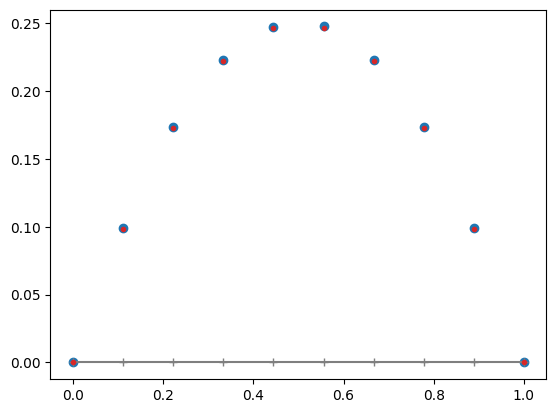

 La tolerancia no se alcanzo, R =0.00831662695526001, se refino nuevamente la malla


In [195]:
uh = myfirstfem1d(problema, mesh)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(mesh.Coordinates, uh,'o',color='C00')
ax.plot(mesh.Coordinates, np.zeros(mesh.NN),'-+',color ='C07')
ax.plot(mesh.Coordinates, uexact(mesh.Coordinates),'.',color ='C03')
plt.show()
success, mesh1 = compute_apostestimator(mesh, uh, problema)

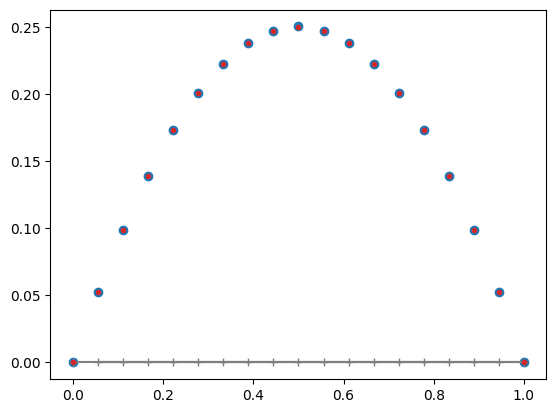

 La tolerancia se alcanzo RR = 0.0014590164379689177, no se refino nuevamente la malla


In [196]:
uhr = myfirstfem1d(problema, mesh1)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(mesh1.Coordinates, uhr,'o',color='C00')
ax.plot(mesh1.Coordinates, np.zeros(mesh1.NN),'-+',color ='C07')
ax.plot(mesh1.Coordinates, uexact(mesh1.Coordinates),'.',color ='C03')
plt.show()
success, mesh2 = compute_apostestimator(mesh1, uhr, problema)

## Problema 3

In [201]:
## New problem
a = 0.0; b= 1.0
f = lambda x: 1.0 +0*x
A = .0; B = .0
p = lambda x: 1.0+0*x
r = lambda x: 10.0+0*x
dp = lambda x: 0*x
q = lambda x: 30+0*x
K0 = (1.0+np.sqrt(500.0))/np.pi**2
problema = problem1delliptic(a,b,f,A,B,p,q,r,dp,K0=K0)

npoints=20
Coordinates = np.linspace(a,b,npoints,endpoint=True)
Elements1d = np.asarray([[i, i+1] for i in range(npoints-1)])
mesh0 = Triangulation1d(Coordinates, Elements1d, Boundary=[0,npoints-1])

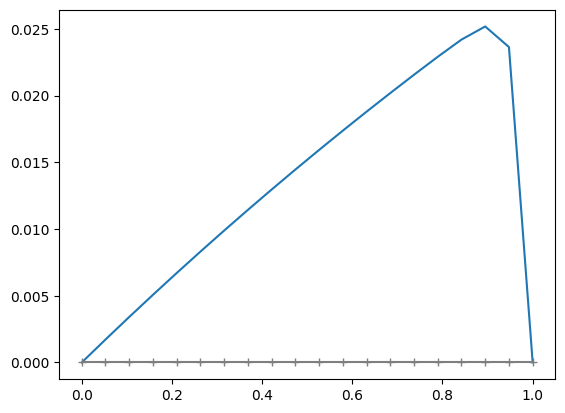

 La tolerancia no se alcanzo, R =0.00912497797099999, se refino nuevamente la malla


In [202]:
uh0 = myfirstfem1d(problema, mesh0)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(mesh0.Coordinates, uh0,'C00')
ax.plot(mesh0.Coordinates, np.zeros(mesh0.NN),'-+',color ='C07')
plt.show()
success, mesh1 = compute_apostestimator(mesh0, uh0, problema, TOL=1e-3)

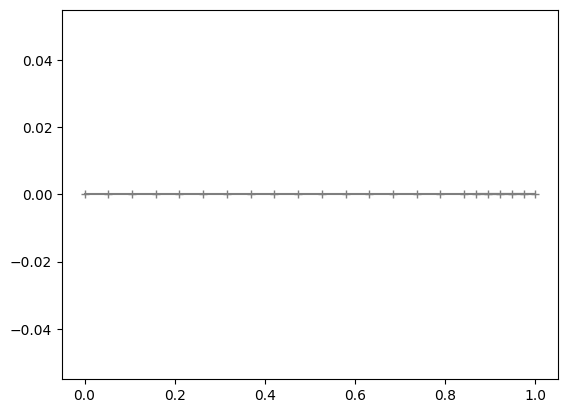

In [203]:
fig = mesh1.plotTriangulation()

In [204]:
uh1 = myfirstfem1d(problema, mesh1)
success, mesh2 = compute_apostestimator(mesh1, uh1, problema, TOL=1e-3)

 La tolerancia no se alcanzo, R =0.0020745756148575593, se refino nuevamente la malla


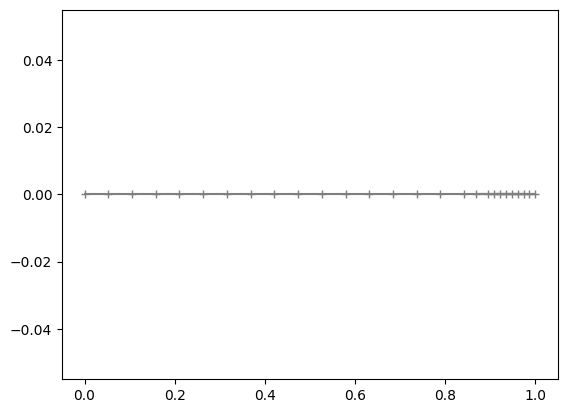

In [205]:
fig = mesh2.plotTriangulation()

 La tolerancia no se alcanzo, R =0.0004278309171032992, se refino nuevamente la malla


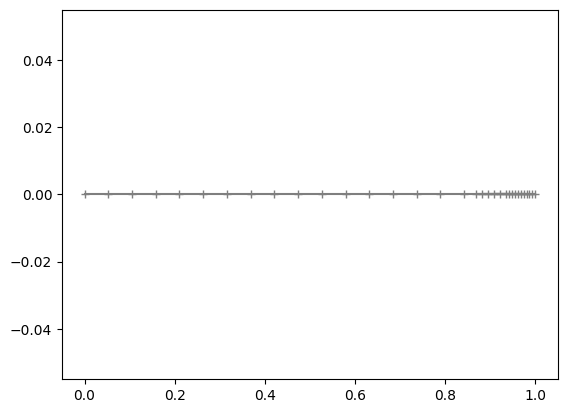

In [206]:
uh2 = myfirstfem1d(problema, mesh2)
success, mesh3 = compute_apostestimator(mesh2, uh2, problema, TOL=1e-3)
fig = mesh3.plotTriangulation()

 La tolerancia se alcanzo RR = 8.249581202153949e-05, no se refino nuevamente la malla


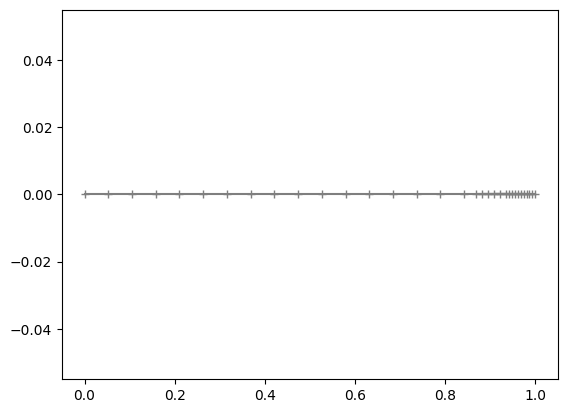

In [207]:
uh3 = myfirstfem1d(problema, mesh3)
success, mesh4 = compute_apostestimator(mesh3, uh3, problema, TOL=1e-3)
fig = mesh4.plotTriangulation()

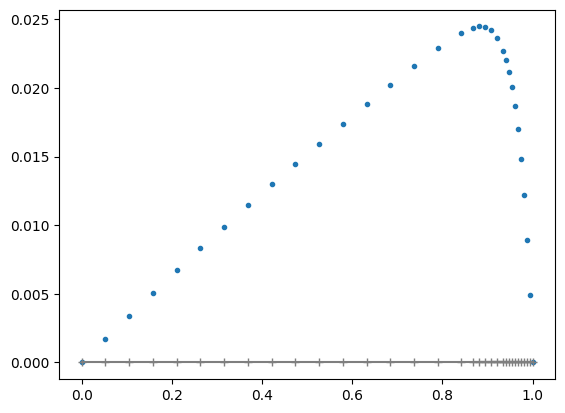

In [210]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(mesh3.Coordinates, uh3,'.')
ax.plot(mesh3.Coordinates, np.zeros(mesh3.NN),'-+',color ='C07')
plt.show()

## Problema 4

\begin{equation}
\epsilon u'' +uu'-u = 0, \quad\text{en }(0,1),\quad u(a) = A,\;u(b) = B 
\end{equation}

In [ ]:
## New problem
a = 0.0; b= 1.0
f = lambda x: 1.0 +0*x
A = .0; B = .0
p = lambda x: 1.0+0*x
r = lambda x: 10.0+0*x
dp = lambda x: 0*x
q = lambda x: 30+0*x
K0 = (1.0+np.sqrt(500.0))/np.pi**2
problema = problem1delliptic(a,b,f,A,B,p,q,r,dp,K0=K0)

npoints=20
Coordinates = np.linspace(a,b,npoints,endpoint=True)
Elements1d = np.asarray([[i, i+1] for i in range(npoints-1)])
mesh0 = Triangulation1d(Coordinates, Elements1d, Boundary=[0,npoints-1])